# Household Power Comsumption Analysis

The data used for this analysis is from https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption

It contains the power consumption of one household located in France with a one-minute sampling rate over almost 4 years.

The goal for this activity is to forecast the next few month's power consumption of the household. From the EDA and clustering results, it was apparent that the household's power consumption has seasonal behaviours - 4 seasons and weekday vs weekend. This notebook is a walkthrough on timeseries forecasting using SARIMA. Seasonal Autoregressive Integrated Moving Average is an extension of ARIMA that accounts for seasonal behavior of a univariate timeseries data. 

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns    
plt.style.use('seaborn-colorblind')
from pylab import rcParams
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error, mean_absolute_error

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import adfuller

import pmdarima as pm
from pmdarima import auto_arima

In [2]:
# load data

filepath = './power_consumption_monthly.csv'

power_consumption_monthly = pd.read_csv(filepath,  header=0, low_memory=False, infer_datetime_format=True, parse_dates=['datetime'], index_col='datetime')
power_consumption_monthly.index = pd.DatetimeIndex(power_consumption_monthly.index.values,
                               freq=power_consumption_monthly.index.inferred_freq)
power_consumption_monthly.head()

,Global_active_power
2006-12-31,41826.806
2007-01-31,69017.296
2007-02-28,56496.828
2007-03-31,58862.721
2007-04-30,36529.192


In [3]:
power_consumption_monthly.tail()

,Global_active_power
2010-07-31,32190.403
2010-08-31,27739.654
2010-09-30,42813.778
2010-10-31,51934.710
2010-11-30,44598.388


## Time series forecasting guidelines

1. Is the time series stationary?
2. If not stationary, which transformation should we apply to make it stationary?
3. Is the time series seasonal?
4. If seasonal what is the seasonal period?
5. Which orders to use? (p for AR, q for MA, P for SAR, Q for SMA)

Since the goal is to forecast the next few month's power consumption, the seasonality factor for this activity is m=12 (12 months in a year). This is also backed up by EDA and clustering results that power consumption has a consistent seasonal behavior yearly.

In [4]:
# filter the 3 full years of monthly global active power only as the training set

monthly = power_consumption_monthly[(power_consumption_monthly.index >= '2007-01-01') & (power_consumption_monthly.index < '2010-01-01')]
monthly.shape

(36, 1)

In [5]:
# filter the 3 full years of monthly global active power and the next 10 full months of global active power (test set)

monthly_forecast = power_consumption_monthly[(power_consumption_monthly.index >= '2007-01-01') & (power_consumption_monthly.index < '2010-11-01')]
monthly_forecast.shape

(46, 1)

### Test for stationarity

Augmented-Dickey Fuller test

Ho: Unit root is present in time series (there is stochastic trend in time series)

Ha: No unit root

If ADF test p-value < 0.05, time series is stationary

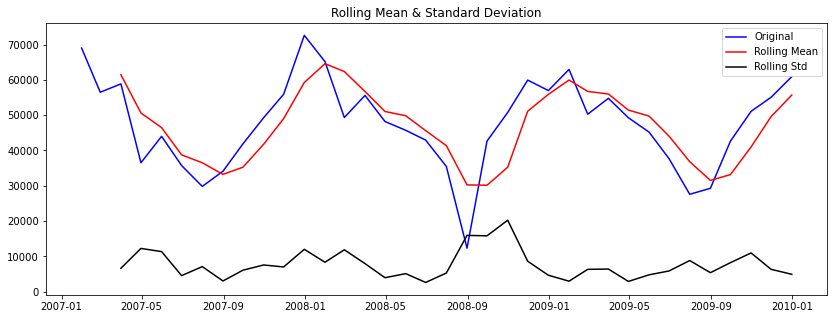

<Results of Dickey-Fuller Test>
Test Statistic                -6.773941e+00
p-value                        2.599382e-09
#Lags Used                     7.000000e+00
Number of Observations Used    2.800000e+01
Critical Value (1%)           -3.688926e+00
Critical Value (5%)           -2.971989e+00
Critical Value (10%)          -2.625296e+00
dtype: float64


In [6]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=3).mean()
    rolstd = timeseries.rolling(window=3).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(monthly.Global_active_power.dropna())

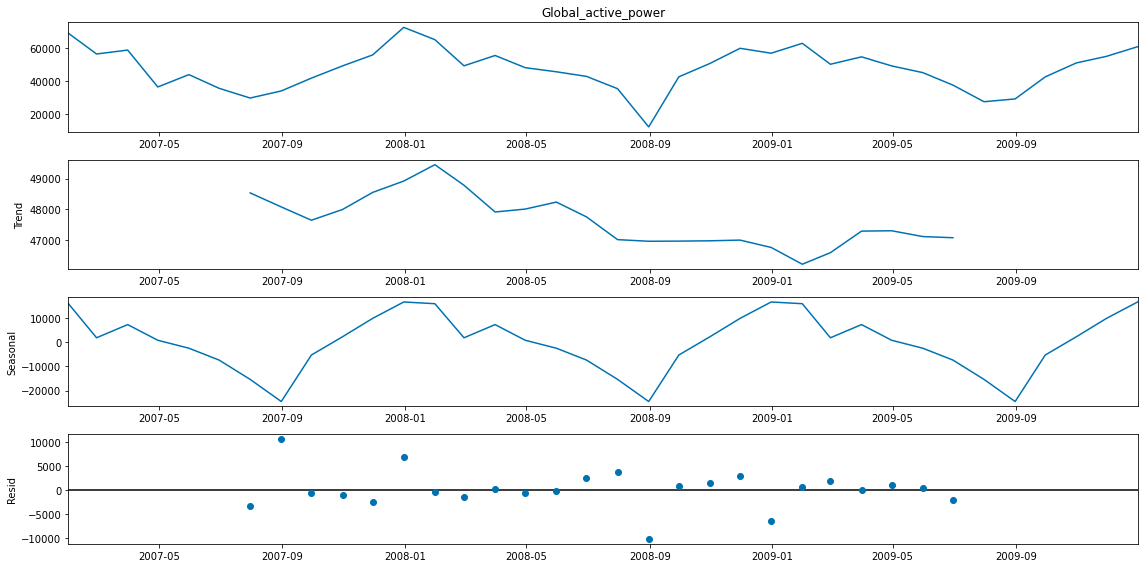

In [7]:
rcParams['figure.figsize'] = 16,8
decomposition = sm.tsa.seasonal_decompose(monthly['Global_active_power'], model='additive')
fig = decomposition.plot()
plt.show()

#### Test for stationarity accounting for seasonality

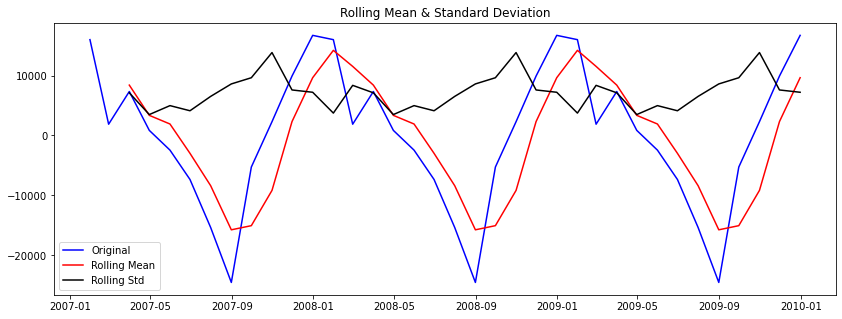

<Results of Dickey-Fuller Test>
Test Statistic                -4.868863e+12
p-value                        0.000000e+00
#Lags Used                     1.000000e+01
Number of Observations Used    2.500000e+01
Critical Value (1%)           -3.723863e+00
Critical Value (5%)           -2.986489e+00
Critical Value (10%)          -2.632800e+00
dtype: float64


In [8]:
seasonal = decomposition.seasonal
test_stationarity(seasonal)

In both ADF tests, p-values were less than 0.05. There is no sufficient evidence to reject Ho, timeseries is stationary. There is no transformation needed.

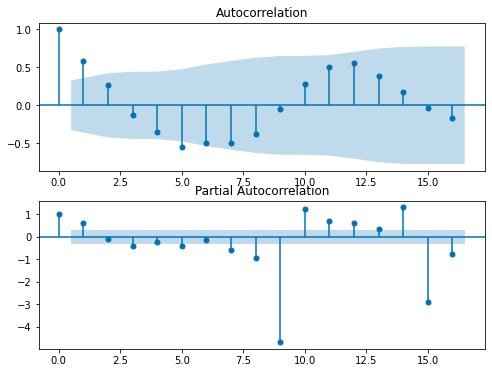

In [9]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,6))
plot_acf(monthly, ax=ax1)
plot_pacf(monthly, ax=ax2)
plt.show()

ACF shows a gradual decrease while PACF cuts down after 1 lag. This suggests AR(1).
If we are to specify the components of SARIMA manually, it'll be SARIMA (1,0,0) x (1,0,0)12.

### Grid search parameters p,q,P,Q using statsmodel

Evaluate using AIC.
<br>
AIC = 2k-2lnL <br>
k is number of parameters <br>
L is maximum likelihood for that function <br>
*we want to lessen the complexity of the model (lessen k) while increasing likelihood/good of fit of the model. We want small value of AIC.

In [10]:
import statsmodels.api as sm
import itertools    

output = []

p = q = range(0, 2)
d = range(0,1)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter for SARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))

Examples of parameter for SARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (1, 0, 0, 12)


In [11]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
            mod = sm.tsa.statespace.SARIMAX(monthly,order=param,seasonal_order=param_seasonal,trend='n')
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
            output.append([param,param_seasonal, results.aic])

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:882.1552231176995
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:862.8378235411636
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:795.6571871689115
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:804.5697542052053
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:861.0055427872909
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:859.7751729402062
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:858.4594031089251
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:860.3132953452686
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:778.079727838954
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:776.002019010425
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:774.5322782919002
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:774.7326552237749
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:780.0913240623069
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:777.0304068376499
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:774.7753765883424
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:774.8865307472107


In [12]:
output = pd.DataFrame(output)
output=output.rename(columns={0: "param", 1: "param_seasonal", 2: "aic"})
output[(output.aic == output.aic.min())]

,param,param_seasonal,aic
10,"(1, 0, 0)","(1, 0, 0, 12)",774.532278


### Grid search parameters p,q,P,Q using auto_arima

Alternatively, auto_arima can also do the trick!

In [13]:
model_monthly = auto_arima(monthly['Global_active_power'], 
                           seasonal=True,
                           m=12, 
                           d=0, 
                           D=0,
                           start_p=0, start_q=0,
                           max_p=1, max_q=1,
                           start_P=0, start_Q=0,
                           max_P=1, max_Q=0,
                           #enforce_stationarity=False,
                           #enforce_invertibility=False,
                          information_criterion='aic',
                          stepwise=True,
                          trace=True,
                          trend='n') #specify trend so it will match output in sm.tsa.statespace.sarimax

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=882.155, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=774.532, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=861.006, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=882.155, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=778.080, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.02 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=774.775, Time=0.08 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=858.459, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12]             : AIC=774.532, Time=0.03 sec

Best model:  ARIMA(1,0,0)(1,0,0)[12]          
Total fit time: 0.229 seconds


Based on the two grid search methods tried, best model is SARIMA (1,0,0) (1,0,0)12. Similar to the manually identified model using ACF and PACF.

In [14]:
model_monthly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   36
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                -384.266
Date:                            Wed, 16 Mar 2022   AIC                            774.532
Time:                                    16:52:52   BIC                            779.283
Sample:                                         0   HQIC                           776.190
                                             - 36                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9546      0.064     15.003      0.000       0.830       1.079
ar.S.L12       0.4318      0.230      1.881      0.060      -0.018       0.882
sigma2      1.144e+08   6.12e-10   1.87e+17      0.000    1.14e+08    1.14e+08
===================================================================================
Ljung-Box (L1) (Q):                   2.74   Jarque-Bera (JB):                 1.42
Prob(Q):                              0.10   Prob(JB):                         0.49
Heteroskedasticity (H):               0.39   Skew:                            -0.13
Prob(H) (two-sided):                  0.12   Kurtosis:                         3.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.61e+33. Standard errors may be unstable.
"""

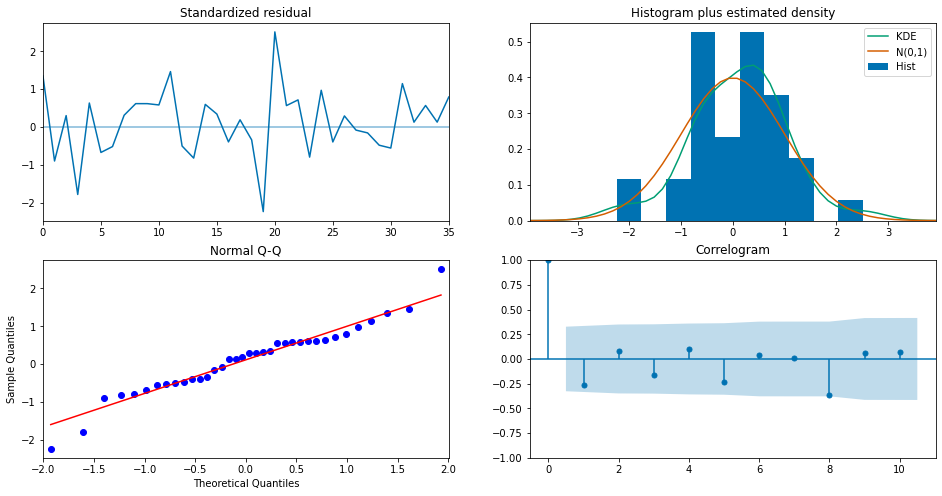

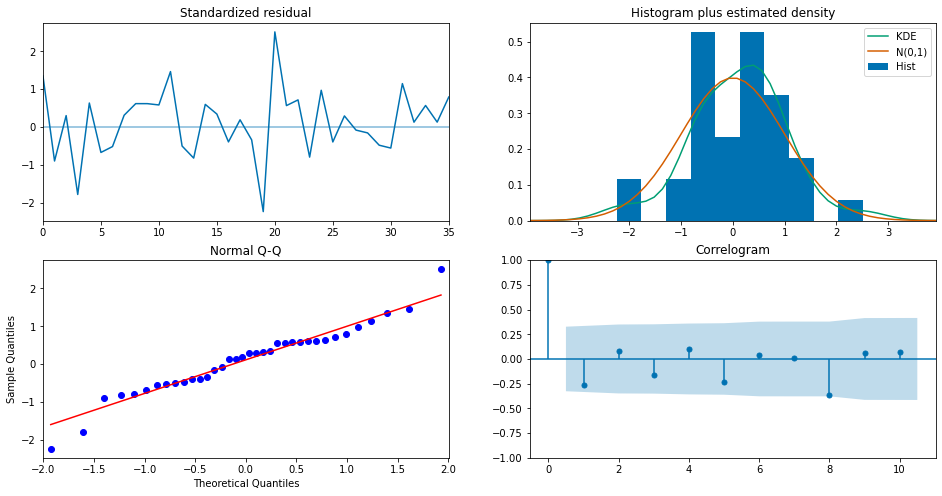

In [15]:
model_monthly.plot_diagnostics()

In [16]:
import statsmodels.api as sm

mod = SARIMAX(monthly['Global_active_power'],
                               order=(1,0,0),
                               seasonal_order=(1,0,0,12),
                               trend='n')
results = mod.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                Global_active_power   No. Observations:                   36
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                -384.266
Date:                            Wed, 16 Mar 2022   AIC                            774.532
Time:                                    16:52:53   BIC                            779.283
Sample:                                01-31-2007   HQIC                           776.190
                                     - 12-31-2009                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9546      0.064     15.003      0.000       0.830       1.079
ar.S.L12       0.4318      0.230   

Ljung–Box test: <br>
Null hypothesis: There are no correlations in the residuals. <br>
Prob(Q) = 0.10 > 0.05. We do not reject Ho. Residuals are uncorrelated.

Jarque–Bera test: <br>
Null hypothesis: Residuals are normally distributed. <br>
Prob(JB) = 0.49 > 0.05. We do not reject Ho. Residuals are normally distributed.

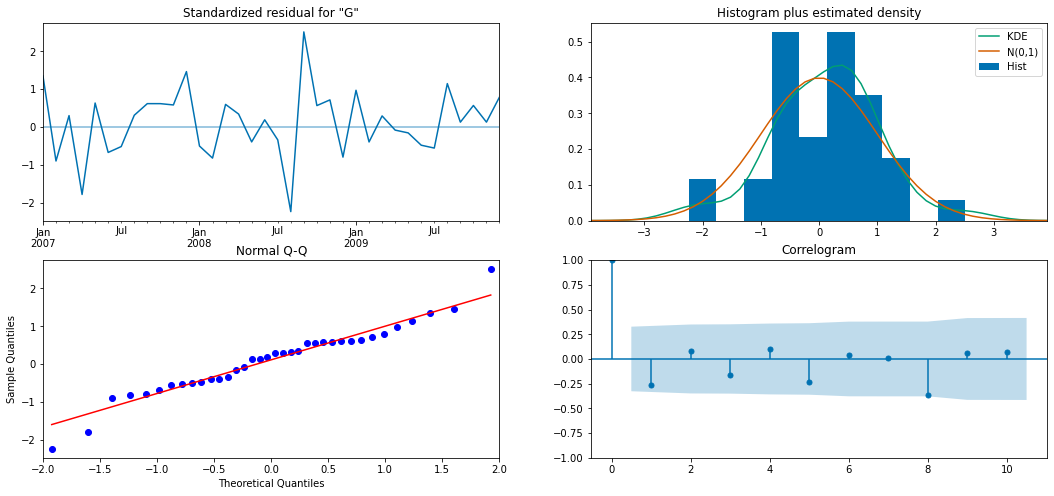

In [17]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

Standardized residual: no patterns, good sign.

Histogram plus kde estimate: slight shift to right of KDE's peak.

Correlogram or ACF plot: 95% of correlations for lag greater than one are inside the blue shaded region, good sign.

Normal Q-Q: most of the data points lie within the straight line except for some extreme points. This indicates a normal distribution of the residuals which we've also proven in the JB test previously.

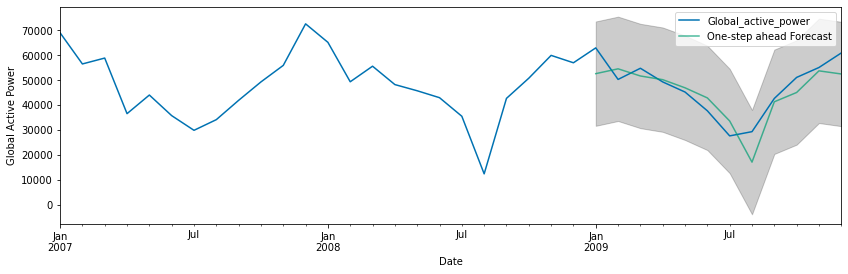

In [18]:
pred = results.get_prediction(start=pd.to_datetime('2009-01-31'), dynamic=False)
pred_ci = pred.conf_int()
ax = monthly['2007':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Global Active Power')
plt.legend()
plt.show()

In [19]:
y_forecasted = pd.DataFrame(pred.predicted_mean)
y_truth = monthly['2009-01-31':]
mae = (y_forecasted['predicted_mean'] - y_truth['Global_active_power']).mean()
mse = ((y_forecasted['predicted_mean'] - y_truth['Global_active_power']) ** 2).mean() 
print('Performance Evaluation Training Set/In-sample')
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))
print('The Mean Absolute Error is {}'.format(round(abs(mae), 2)))

Performance Evaluation Training Set/In-sample
The Mean Squared Error is 38575651.13
The Root Mean Squared Error is 6210.93
The Mean Absolute Error is 2070.28


In [20]:
y_test_predict = pd.DataFrame(results.predict(start = 36, end = 45, dynamic= False)) 
y_test = monthly_forecast['2010-01-31':'2010-10-31']
mae = (y_test_predict['predicted_mean'] - y_test['Global_active_power']).mean()
mse = ((y_test_predict['predicted_mean'] - y_test['Global_active_power']) ** 2).mean()
print('Performance Evaluation Testing Set/Out-of-sample')
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))
print('The Mean Absolute Error is {}'.format(round(abs(mae), 2)))

Performance Evaluation Testing Set/Out-of-sample
The Mean Squared Error is 27766012.48
The Root Mean Squared Error is 5269.35
The Mean Absolute Error is 1847.2


In [21]:
y_forecast_new = pd.DataFrame(results.predict(start = 46, end = 50, dynamic= False)) 

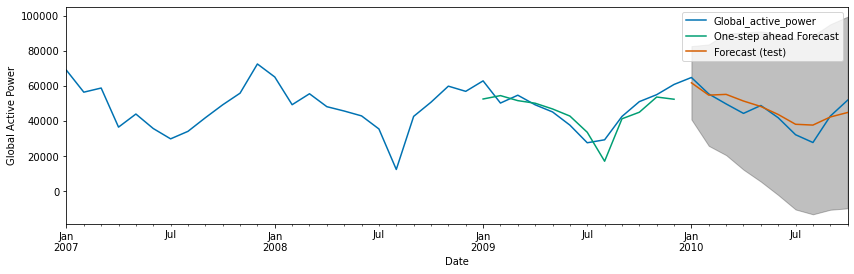

In [22]:
pred_uc = results.get_forecast(steps=10)
pred_ci = pred_uc.conf_int()
ax = monthly_forecast.plot(label='observed', figsize=(14, 4))
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast')
pred_uc.predicted_mean.plot(ax=ax, label='Forecast (test)')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Global Active Power')
plt.legend()
plt.show()

### Forecasting for the next 12 months

In [23]:
import statsmodels.api as sm

mod = sm.tsa.statespace.SARIMAX(monthly_forecast['Global_active_power'],
                               order=(1,0,0),
                                seasonal_order=(1,0,0,12),
                               trend='n')
results = mod.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                Global_active_power   No. Observations:                   46
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                -486.726
Date:                            Wed, 16 Mar 2022   AIC                            979.452
Time:                                    16:52:54   BIC                            984.938
Sample:                                01-31-2007   HQIC                           981.507
                                     - 10-31-2010                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9473      0.057     16.598      0.000       0.835       1.059
ar.S.L12       0.5041      0.184   

Ljung–Box test:

Null hypothesis: There are no correlations in the residuals.

Prob(Q) = 0.07 > 0.05. We do not reject Ho. Residuals are uncorrelated.

Jarque–Bera test:

Null hypothesis: Residuals are normally distributed.

Prob(JB) = 0.16 > 0.05. We do not reject Ho. Residuals are normally distributed.

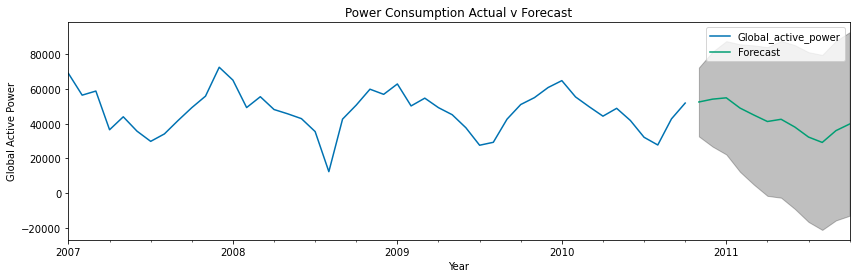

In [27]:
pred_uc = results.get_forecast(steps=12)
pred_ci = pred_uc.conf_int()
ax = monthly_forecast.plot(label='observed', figsize=(14, 4))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Year')
ax.set_ylabel('Global Active Power')
ax.set_title('Power Consumption Actual v Forecast')
plt.legend()
plt.show()

In [25]:
y_forecast_new = pd.DataFrame(results.predict(start = 46, end = 58, dynamic= False)) 
y_forecast_new

,predicted_mean
2010-11-30,52562.203252
2010-12-31,54199.246894
2011-01-31,54962.850579
2011-02-28,49049.931295
2011-03-31,45069.970069
2011-04-30,41291.845112
2011-05-31,42571.322488
2011-06-30,38095.119614
2011-07-31,32311.824639
2011-08-31,29220.679630


SARIMA was used to forecast the global active power for the next 12 months. 
Monthly global active power from 2007 to 2009 was used as training test while 2010 was used as testing set.

Based on the in-sample prediction, the SARIMA model got an RMSE of 6210.93. 
However, using the SARIMA model to forecast the monthly consumption and comparing it with the testing set, RMSE was slightly lower at 5269.35.

Using this SARIMA model, we tried to forecast the next 12 months. Based on the visualization above, we can see that the forecast was able to capture the seasonality observed in time points. Note that AR/MA/ARMA/ARIMA/SARIMA models are best for making short term predictions. The models lose predictive power for large future horizons. This can be observed in the last few forecasted values in the above table.